<a href="https://www.kaggle.com/code/hari141v/solafune-finding-mining-sites-embeddings-xgb?scriptVersionId=194667922" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### About
### Develop a technology for detecting mining sites using images from the optical satellite Sentinel-2. Specifically, it involves classifying images that contain mining sites and those that do not.

### Competition hosted on [Solafune](https://solafune.com/competitions/58406cd6-c3bb-4f7a-85c7-c5a1ad67ca03?menu=about&tab=overview&modal=%22%22)



### Competiton Policy

### cf. @solafune(https://solafune.com) Use for any purpose other than participation in the competition or commercial use is prohibited. If you would like to use them for any of the above purposes, please contact us.

### Import necessary libraries and packages

In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
from tqdm import tqdm
import xgboost as xgb
from PIL import Image, ImageDraw #for read the image
import skimage.color 
import skimage.util

import cv2 #for read the image
import os
import re
import itertools
#import distance
import time
import warnings
warnings.filterwarnings("ignore")


import torch
from torch import nn
import timm
import torch.nn.functional as F
import rasterio
from torchvision import transforms
import tifffile

from sklearn.metrics import f1_score,classification_report,confusion_matrix,log_loss,ConfusionMatrixDisplay,roc_curve,precision_recall_curve

### Import data

In [2]:
train=pd.read_csv("/kaggle/input/solafune-finding-mining-sites/train/answer.csv")
test=pd.read_csv("/kaggle/input/solafune-finding-mining-sites/uploadsample.csv")
train_path="/kaggle/input/solafune-finding-mining-sites/train/train/"
test_path="/kaggle/input/solafune-finding-mining-sites/evaluation_images/"

In [3]:
train=train.rename(columns={'train_0.tif':'filename'})
train=train.rename(columns={'0':'label'})
test=test.rename(columns={'evaluation_0.tif':'filename'})
test=test.rename(columns={'0':'label'})

### Let's split the train data for train and validate

In [4]:
X_train, X_test = train_test_split(train, test_size=0.3,random_state=42,
                                                                   stratify=train['label'])

### In the following steps, the image embeddings are extracted from a pre-trained model and used to train an XGBoost model.

In [5]:
model_name = 'efficientnet_b0.ra_in1k'
model = timm.create_model(model_name, pretrained=True, num_classes=0)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Convert tensors to pil-image

In [6]:
tensor_to_pil = transforms.ToPILImage()

### Helper function to get the embeddings.

In [7]:
def get_image_embedding(df,path):
    embed=[]
    model.eval()
    data_config = timm.data.resolve_model_data_config(model)
    transform_model = timm.data.create_transform(**data_config, is_training=False)
    for img in tqdm_notebook(df['filename']):
        im=rasterio.open(f"{path}{img}").read().astype(np.float64)
        im=torch.from_numpy(im)
        im=F.interpolate(im.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        im=tensor_to_pil(im[1:4])
        output = model(transform_model(im).unsqueeze(0))
        embed.append(output.detach().cpu().numpy())
        del im,output
    return embed
    

### Extract embeddings for train data

In [8]:
train_embeddings=get_image_embedding(X_train,train_path)

  0%|          | 0/868 [00:00<?, ?it/s]

### Extract embeddings for validation data

In [9]:
validation_embeddings=get_image_embedding(X_test,train_path)

  0%|          | 0/373 [00:00<?, ?it/s]

### Baseline Xgboost model

In [10]:
clf=xgb.XGBClassifier(random_state=42)

### Train the model

In [11]:
clf.fit(np.concatenate(train_embeddings), X_train['label'],
        eval_set=[(np.concatenate(validation_embeddings),X_test['label'])],eval_metric=['error','logloss'],
        early_stopping_rounds=200, verbose=True)

[0]	validation_0-error:0.20643	validation_0-logloss:0.43548
[1]	validation_0-error:0.16622	validation_0-logloss:0.38514
[2]	validation_0-error:0.15550	validation_0-logloss:0.35810
[3]	validation_0-error:0.13673	validation_0-logloss:0.34386
[4]	validation_0-error:0.12332	validation_0-logloss:0.32079
[5]	validation_0-error:0.13405	validation_0-logloss:0.31050
[6]	validation_0-error:0.11528	validation_0-logloss:0.30556
[7]	validation_0-error:0.12601	validation_0-logloss:0.29917
[8]	validation_0-error:0.11528	validation_0-logloss:0.29582
[9]	validation_0-error:0.11528	validation_0-logloss:0.29780
[10]	validation_0-error:0.11528	validation_0-logloss:0.30271
[11]	validation_0-error:0.11528	validation_0-logloss:0.30258
[12]	validation_0-error:0.12332	validation_0-logloss:0.30222
[13]	validation_0-error:0.12064	validation_0-logloss:0.30254
[14]	validation_0-error:0.12064	validation_0-logloss:0.30235
[15]	validation_0-error:0.11528	validation_0-logloss:0.30090
[16]	validation_0-error:0.11528	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Predict the validation data

In [12]:
val_pred=clf.predict(np.concatenate(validation_embeddings))

### F1 score for validation data(default threshold)

In [13]:
print(f"Validation data accuracy:{f1_score(X_test['label'],val_pred,).round(2)*100}")

Validation data accuracy:69.0


### Confusion matrix report

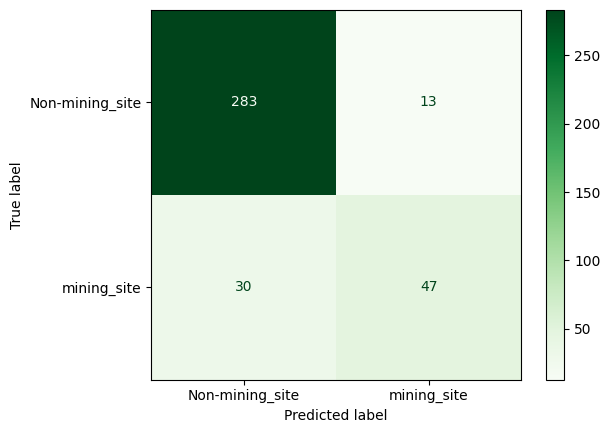

In [14]:
cm = confusion_matrix(X_test['label'],val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Non-mining_site','mining_site'])
disp.plot(cmap='Greens')
plt.show()

### Threshold Tuning

In [15]:
def optimal_threshold(y_true,y_prediction):
    def to_class_label(probs, threshold):
        """convert predicted probabilities to class labels"""
        return (probs >= threshold).astype('int')

    def get_optimal_threshold(y_true, y_prediction):
        """Threshold tuning"""
        thresholds = np.arange(0, 1, 0.0001)
        #y_hat = fitted_model.predict_proba(x_test)
        #pos_clas_probs = y_hat[:, 1]
        f1_scores = [f1_score(y_true, to_class_label(y_prediction, thres)) for thres in thresholds]
        idx = np.argmax(f1_scores)
        return idx,f1_scores,thresholds[idx]

    score,list_score,opt_thres = get_optimal_threshold(y_true, y_prediction)
    print(f'Optimal threshold {opt_thres:.5f}')
    fig, (thresh_plot,conf) = plt.subplots(2,1,figsize=(12,8))
    thresh_plot.plot(np.arange(0, 1, 0.0001), list_score,'k',color='red')
    thresh_plot.scatter(np.arange(0, 1, 0.0001)[score], list_score[score], marker='o', color='green',
                        label=f"Best Threshold:{opt_thres:.5f}\nF1-Score:{list_score[score]:.5f}")
    thresh_plot.set_title(f"Probability Threshold Tuning",fontsize=15)
    thresh_plot.legend()
    thresh_plot.set_xlabel('Threshold')
    thresh_plot.set_ylabel('F1-Score')
    
    y_pred_class=[1 if p>opt_thres else 0 for p in y_prediction]
    clf_report = classification_report(y_true,
                               y_pred_class,output_dict=True,)
    tab=conf.table(cellText=pd.DataFrame(clf_report).values.round(5),
                   colLabels=pd.DataFrame(clf_report).columns,
               rowLabels=['precision','recall','f1-score','support'],loc="center")
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    tab.scale(1.5,3)
    conf.set_axis_off()
    conf.set_xticks([])
    conf.set_yticks([])
    plt.show()
    
    

### Predict probability values for validation data

In [16]:
val_pred_proba=clf.predict_proba(np.concatenate(validation_embeddings))[:,1]

### Finding optimal threshold

Optimal threshold 0.36810


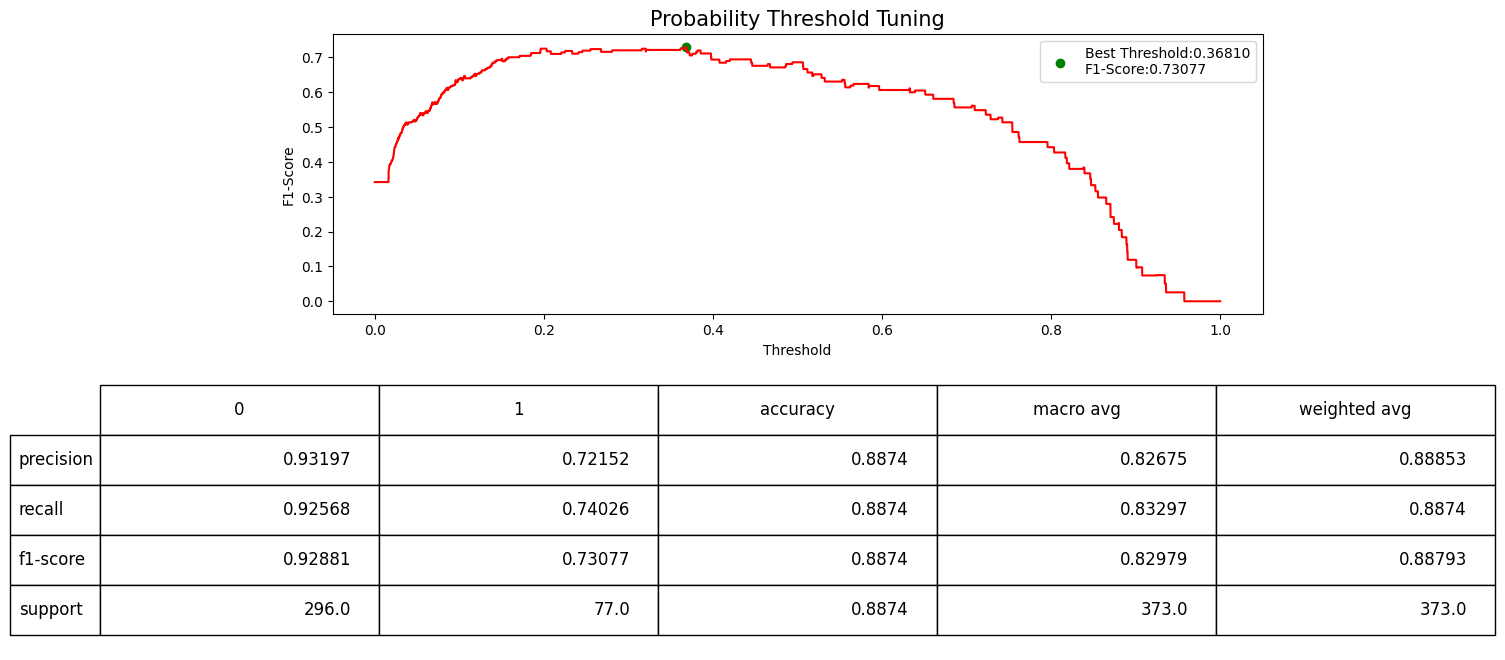

In [17]:
optimal_threshold(X_test['label'],val_pred_proba)

### F1 score for validation data(tuned threshold)

In [18]:
print(f"Validation data accuracy:{f1_score(X_test['label'],pd.Series([1 if i>  0.36810 else  0 for i in  val_pred_proba ]),).round(2)*100}")

Validation data accuracy:73.0


### Confusion matrix report

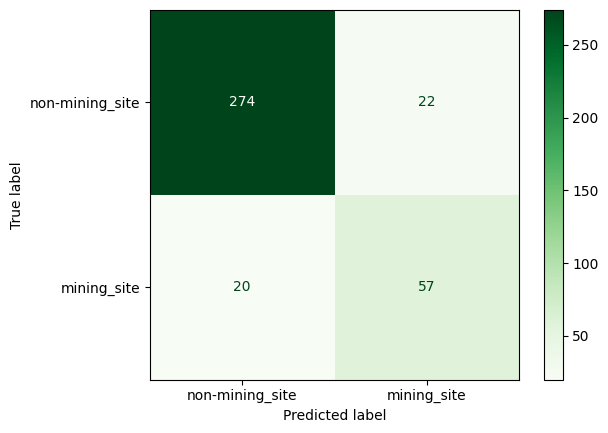

In [19]:
cm = confusion_matrix(X_test['label'],pd.Series([1 if i>  0.36810 else  0 for i in  val_pred_proba ]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['non-mining_site','mining_site'])
disp.plot(cmap='Greens')
plt.show()

### Extract embeddings for test data

In [ ]:
test_embeddings=get_image_embedding(test,test_path)

  0%|          | 0/1242 [00:00<?, ?it/s]

### Predict the test data

In [ ]:
test_pred=clf.predict_proba(np.concatenate(test_embeddings))[:,1]

In [ ]:
res=pd.concat([test['filename'],pd.Series([1 if i>  0.36810 else  0 for i in  test_pred ])],axis=1)

In [ ]:
res.head()

In [ ]:
res[0].value_counts()

In [ ]:
res.to_csv("efficientnet_b0.ra_in1k_embeddings_xgb_baseline_1_optimal_threshold.csv",index=False,header=False)